Import packages for plots and model

In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Define URL and Ticker(s) to be scanned

In [2]:
finviz_url= 'https://finviz.com/quote.ashx?t='
tickers = ['NGA', 'SPCE', 'RUN', 'CCIV', 'QS']

Create a dictionary of ticker symbols and there respective news headlines

In [3]:
news_tables= {}

for ticker in tickers:
    url= finviz_url + ticker
    
    req= Request(url=url, headers={'user-agent': 'my-app'})
    response= urlopen(req)
    
    html= BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [4]:
print(news_tables)

{'NGA': <table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer" id="news-table" width="100%">
<tr><td align="right" style="white-space:nowrap" width="130">Feb-25-21 09:44AM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/lion-electric-bring-zero-emission-144400075.html" target="_blank">Lion Electric to Bring Zero Emission School Buses to Californias Largest School District</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Business Wire</span> <span class="body-table-news-gain">+7.99%</span></div></div></td></tr>
<tr><td align="right" style="white-space:nowrap" width="130">Feb-12-21 02:58PM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/why-investors-avoid-northern-genesis-195812560.html" target="_blank">Why Investors Should Avoid Northern G

Iterate over the news table dictionary to parse out ticker symbol, date,
time, and title into a list; then convert it into a DataFrame

In [5]:
parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

news_score = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
news_score['date'] = pd.to_datetime(news_score.date).dt.date

In [6]:
#print out the newly created Data Frame that we will run the model on
news_score

,ticker,date,time,title
0,NGA,2021-02-25,09:44AM,Lion Electric to Bring Zero Emission School Bu...
1,NGA,2021-02-12,02:58PM,Why Investors Should Avoid Northern Genesis Stock
2,NGA,2021-02-08,10:00AM,Why Northern Genesis Acquisition Stock Soared ...
3,NGA,2021-01-26,04:01PM,Lion Electric and FLO | AddEnergie Deepen thei...
4,NGA,2021-01-19,07:00AM,Autobus Séguin Turns to Electrification with O...
...,...,...,...,...
348,QS,2021-02-20,04:37PM,INVESTOR REMINDER: Kessler Topaz Meltzer & Ch...
349,QS,2021-02-20,07:48AM,2 Electric Vehicle Stocks Endorsed by Wall Str...
350,QS,2021-02-20,07:45AM,SHAREHOLDER DEADLINE REMINDER: The Schall Law ...
351,QS,2021-02-19,10:50PM,SHAREHOLDER ALERT BY FORMER LOUISIANA ATTORNEY...


Update the Analyzer model with new words and weights for sentiment

In [7]:
# New words and values for evaluating sentiment in headlines
new_words = {
    'crushes': +50,
    'beats': +50,
    'delays': -50,
    'drops': -30,
    'misses': -50,
    'trouble': -50,
    'falls': -30,
    'merger': +100,
    'acquisition': +100,
    'finalizes': +100,
    'law firm': -20,
    'new': +20,
    'problem': -20,
    'partnership': +100,
    'losses': -50,
    'lawsuit': -50,
    'lawsuits': -50,
    'class action': -50,
    'doubles': +70,
    'triples': +100,
    'buy': +50
}

vader = SentimentIntensityAnalyzer()

#Update analyzer with new words
vader.lexicon.update(new_words)

Apply the vader function to analyze each headline and assign a value('compound'), that ranges from -1 to +1 (-1: extremely negative, 0: neutral, +1: extremely positive)

In [8]:
f = lambda title: vader.polarity_scores(title)['compound']
news_score['compound'] = news_score['title'].apply(f)


Create a new DataFrame from the original that is bounded by a time window (Some stocks may have many news headlines in a row and may make reading the chart difficult, thus we limit it to how far back we want the model to interpret news)

In [9]:
import datetime
d1= datetime.date(2021,1,1)
news_score_range= news_score[news_score.date > d1]
news_score_range= pd.DataFrame(news_score_range)

Print out our DataFrame which now stores our model's prediction in the 'compound' column:

In [10]:
news_score_range

,ticker,date,time,title,compound
0,NGA,2021-02-25,09:44AM,Lion Electric to Bring Zero Emission School Bu...,0.0000
1,NGA,2021-02-12,02:58PM,Why Investors Should Avoid Northern Genesis Stock,-0.2960
2,NGA,2021-02-08,10:00AM,Why Northern Genesis Acquisition Stock Soared ...,0.9993
3,NGA,2021-01-26,04:01PM,Lion Electric and FLO | AddEnergie Deepen thei...,0.9851
4,NGA,2021-01-19,07:00AM,Autobus Séguin Turns to Electrification with O...,0.0000
...,...,...,...,...,...
348,QS,2021-02-20,04:37PM,INVESTOR REMINDER: Kessler Topaz Meltzer & Ch...,-0.9972
349,QS,2021-02-20,07:48AM,2 Electric Vehicle Stocks Endorsed by Wall Str...,-0.2960
350,QS,2021-02-20,07:45AM,SHAREHOLDER DEADLINE REMINDER: The Schall Law ...,-0.9992
351,QS,2021-02-19,10:50PM,SHAREHOLDER ALERT BY FORMER LOUISIANA ATTORNEY...,-0.9968


Plot the results of our models prediction using the avg sentiment of the day's headlines for each of our target stocks:

array([<AxesSubplot:title={'center':'CCIV'}, xlabel='date'>,
       <AxesSubplot:title={'center':'NGA'}, xlabel='date'>,
       <AxesSubplot:title={'center':'QS'}, xlabel='date'>,
       <AxesSubplot:title={'center':'RUN'}, xlabel='date'>,
       <AxesSubplot:title={'center':'SPCE'}, xlabel='date'>], dtype=object)

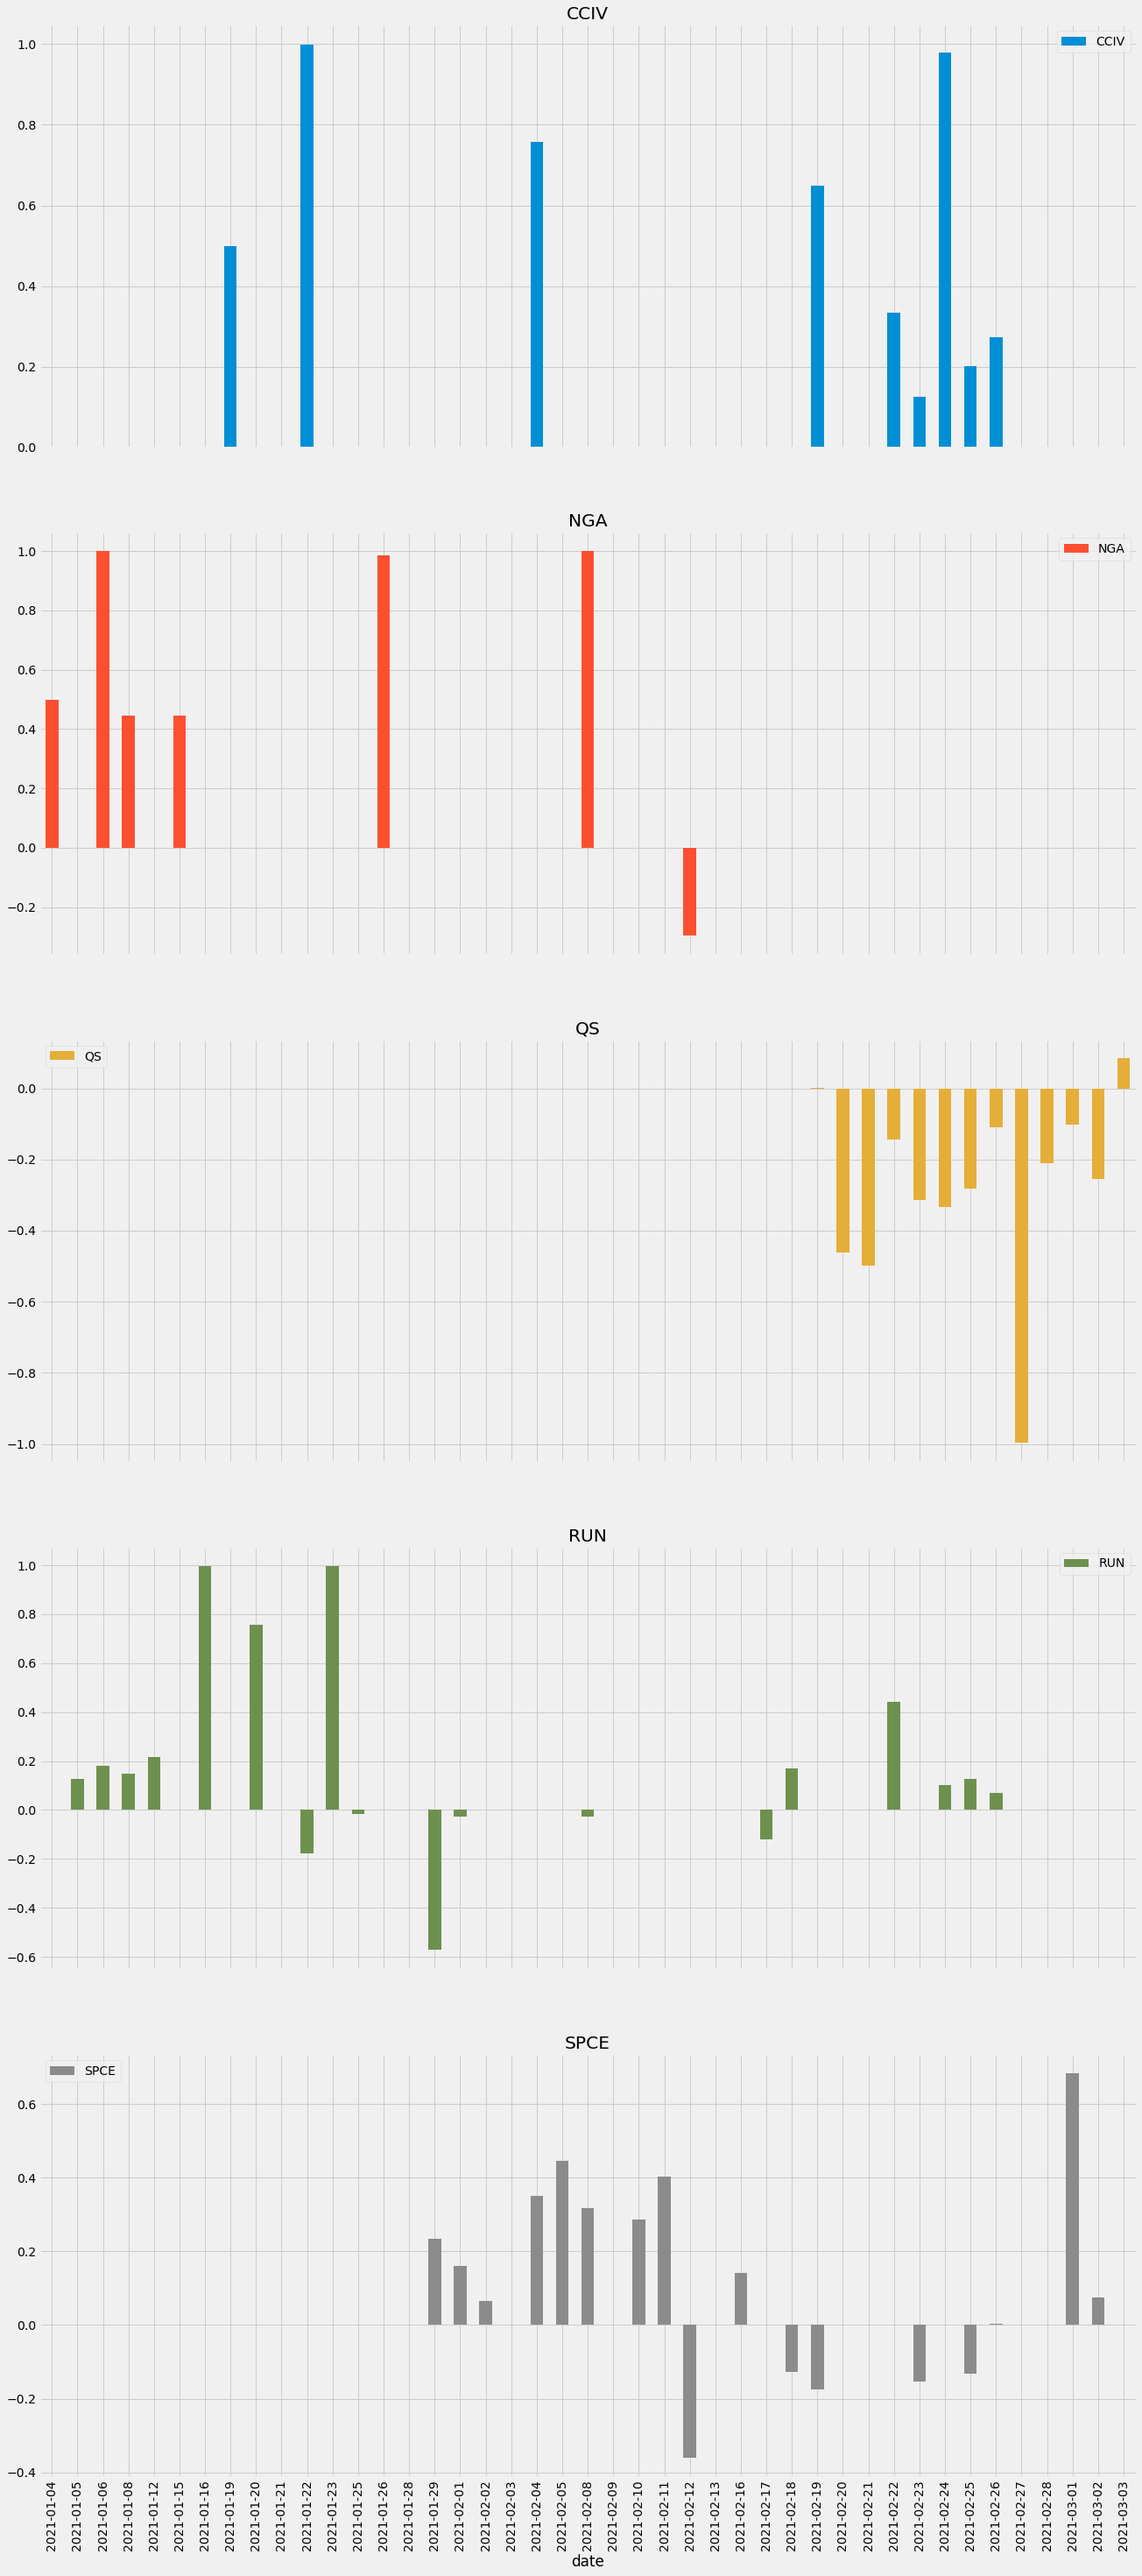

In [11]:
plt.style.use("fivethirtyeight")

mean_ns= news_score_range.groupby(['date', 'ticker']).mean().unstack()
mean_ns= mean_ns.xs('compound', axis="columns")
mean_ns.plot.bar(figsize= (20, len('compound')*6), subplots=True)